In [1]:
from ANEMO import ANEMO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.10'

# Loading eye movement data


In [2]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [3]:
from edfreader import read_edf
datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [4]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [5]:
def Fit(data, nb=10, plot=True, nb_plot=10) :

    result_fit={'start_anti':[], 'start_anti2':[], 'v_anti':[], 'v_anti2':[],
                'latence':[], 'latence2':[], 'old_latence':[],
                'tau':[], 'tau2':[], 'maxi':[], 'maxi2':[], 'old_max':[]}

    if plot is True :
        fig, axs = plt.subplots(nb_plot, 1, figsize=(15, nb_plot*(15*1/2)/1.6180))
    
    
    for trial_data in range(nb) :

        if trial_data < 200 :
            block = 0
        elif trial_data < 400 :
            block = 1
        else :
            block = 2

        trial = trial_data - N_trials*block #trial_data = trial + N_trials*block

        data_x = data[trial_data]['x']
        data_y = data[trial_data]['y']
        trackertime = data[trial_data]['trackertime']

        StimulusOn = data[trial_data]['events']['msg'][10][0]
        StimulusOf = data[trial_data]['events']['msg'][14][0]
        TargetOn = data[trial_data]['events']['msg'][15][0]
        TargetOff = data[trial_data]['events']['msg'][16][0]
        saccades = data[trial_data]['events']['Esac']
        trackertime_0 = data[trial_data]['trackertime'][0]
        bino = p[trial, block, 0]
        
        gradientx_deg =ANEMO.velocity_deg(data_x, exp['px_per_deg']) 
        gradienty_deg =ANEMO.velocity_deg(data_y, exp['px_per_deg']) 
        
        
        #-------------------------------------------------
        # SUPPRESSION DES SACCADES
        #-------------------------------------------------
        stop_recherche_misac = TargetOn-trackertime_0+100
        misac = ANEMO.Microsaccade(gradientx_deg[:stop_recherche_misac], gradienty_deg[:stop_recherche_misac], trackertime_0=trackertime_0)
        saccades.extend(misac)

        gradient_deg_NAN = ANEMO.suppression_saccades(gradientx_deg, saccades, trackertime)
        #-------------------------------------------------

        start = TargetOn
        StimulusOn_s = StimulusOn - start
        StimulusOf_s = StimulusOf - start
        TargetOn_s = TargetOn - start
        TargetOff_s = TargetOff - start
        trackertime_s = trackertime - start

        debut  = TargetOn - trackertime_0
        vitesse, x = gradient_deg_NAN, np.arange(len(trackertime))

        #-------------------------------------------------
        # FIT
        #-------------------------------------------------

        result_deg = ANEMO.Fit_exponentiel(gradient_deg_NAN, trackertime, TargetOn=TargetOn,
                                           StimulusOf=StimulusOf, saccades=saccades, bino=bino)

        result_fit['start_anti'].append(result_deg.values['start_anti']-debut)
        result_fit['v_anti'].append(result_deg.values['v_anti'])
        result_fit['latence'].append(result_deg.values['latence']-debut)
        result_fit['tau'].append(result_deg.values['tau'])
        result_fit['maxi'].append(result_deg.values['maxi'])
        #-------------------------------------------------
        
        
        #-----------------------------------------------------------------------------------------------------------
        # FIT avec vieux paramètres
        # TODO faire une fonction + import from ANEMO
        #-----------------------------------------------------------------------------------------------------------
        """ /!\ vérifier si c'est bien ça """
        
        tau_init = [15.,13.,80.]
        maxi_init = [15.,1.,40.]
        latence_init = [TargetOn-trackertime_0+100,TargetOn-trackertime_0+75,'STOP']
        start_anti_init = [TargetOn-trackertime_0-100, StimulusOf-trackertime_0-200, TargetOn-trackertime_0-75]
        v_anti_init = [0.,-40.,40.]
        
        
        a, b = StimulusOn-trackertime_0, StimulusOf-trackertime_0
        c, seuil = TargetOn-trackertime_0+100, 3
        lat = np.where(np.abs(gradient_deg_NAN[c:]) > np.abs(np.nanmean(gradient_deg_NAN[a:b]))+np.abs(np.nanstd(gradient_deg_NAN[a:b])*seuil))
        old_latence = lat[0][0]+c
        result_fit['old_latence'].append(old_latence-debut)
        
        
        a1, b1 = TargetOn-trackertime_0+400, TargetOn-trackertime_0+600
        maxmax = np.where(np.abs(gradient_deg_NAN) > np.abs(np.nanmean(gradient_deg_NAN[a1:b1])))
        old_max = np.abs(gradient_deg_NAN[maxmax[0][0]])
        result_fit['old_max'].append(old_max)
        
        
        maxi2_init = [old_max,1.,40.]
        #latence2_init = [old_latence-100,TargetOn-trackertime_0+50,'STOP']
        latence2_init = [old_latence,TargetOn-trackertime_0+50,'STOP']

        param_fit2 = {'tau':tau_init, 'maxi':maxi2_init, 'v_anti':v_anti_init, 'latence':latence2_init, 'start_anti':start_anti_init}

        
        result_deg2 = ANEMO.Fit_exponentiel(gradient_deg_NAN, trackertime, param_fit=param_fit2,
                                            TargetOn=TargetOn, StimulusOf=StimulusOf, saccades=saccades, bino=bino)
        
        result_fit['start_anti2'].append(result_deg2.values['start_anti']-debut)
        result_fit['v_anti2'].append(result_deg2.values['v_anti'])
        result_fit['latence2'].append(result_deg2.values['latence']-debut)
        result_fit['tau2'].append(result_deg2.values['tau'])
        result_fit['maxi2'].append(result_deg2.values['maxi'])
        #-------------------------------------------------
        
        
        if trial_data < nb_plot :
            
            axs[trial_data].axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
            axs[trial_data].axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
            axs[trial_data].axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
            for s in range(len(saccades)) :
                axs[trial_data].axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

            axs[trial_data].axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])
            axs[trial_data].plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.6)
            
            init_fit = ANEMO.fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti_init[0],
                                             v_anti_init[0], latence_init[0], tau_init[0], maxi_init[0])
            best_fit = ANEMO.fct_exponentiel(np.arange(len(trackertime[:-250])), bino, result_fit['start_anti'][trial_data]+debut, result_fit['v_anti'][trial_data],
                                             result_fit['latence'][trial_data]+debut, result_fit['tau'][trial_data], result_fit['maxi'][trial_data])
            axs[trial_data].plot(trackertime_s[:-250], init_fit, 'r--', linewidth=1)
            axs[trial_data].plot(trackertime_s[:-250], best_fit, color='r', linewidth=1)

            init_fit2 = ANEMO.fct_exponentiel(np.arange(len(trackertime[:-250])), bino, start_anti_init[0], v_anti_init[0], latence2_init[0], tau_init[0], maxi2_init[0])
            best_fit2 = ANEMO.fct_exponentiel(np.arange(len(trackertime[:-250])), bino, result_fit['start_anti2'][trial_data]+debut, result_fit['v_anti2'][trial_data],
                                              result_fit['latence2'][trial_data]+debut, result_fit['tau2'][trial_data], result_fit['maxi2'][trial_data])
            axs[trial_data].plot(trackertime_s[:-250], init_fit2, 'g--', linewidth=1)
            axs[trial_data].plot(trackertime_s[:-250], best_fit2, color='g', linewidth=1)
            
            axs[trial_data].plot(trackertime_s, np.ones(np.shape(trackertime_s)[0])*(bino*2-1)*result_fit['old_max'][trial_data], color='k', alpha=0.2)
            axs[trial_data].bar(result_fit['old_latence'][trial_data], 80, bottom=-40, color='g', width=4, linewidth=0)

            axs[trial_data].text(StimulusOn_s+15, 18, "start_anti: %0.3f \nv_anti: %0.3f"%(result_fit['start_anti'][trial_data], result_fit['v_anti'][trial_data]), color='k', fontsize=14, va='bottom')
            axs[trial_data].text(StimulusOn_s+15, -18, "latence: %0.3f \nmaxi: %0.3f \ntau: %0.3f"%(result_fit['latence'][trial_data], result_fit['maxi'][trial_data], result_fit['tau'][trial_data]), color='k', fontsize=14, va='top')
            axs[trial_data].text(StimulusOn_s+400, 18, "start_anti: %0.3f \nv_anti: %0.3f"%(result_fit['start_anti2'][trial_data], result_fit['v_anti2'][trial_data]), color='k', fontsize=14, va='bottom')
            axs[trial_data].text(StimulusOn_s+400, -18, "latence: %0.3f \nmaxi: %0.3f \ntau: %0.3f"%(result_fit['latence2'][trial_data], result_fit['maxi2'][trial_data], result_fit['tau2'][trial_data]), color='k', fontsize=14, va='top')
            axs[trial_data].text(StimulusOn_s+800, -18, "lat: %0.3f \nmaximax: %0.3f"%(result_fit['old_latence'][trial_data], result_fit['old_max'][trial_data]), color='k', fontsize=14, va='top')
    
    if plot is True :
        plt.show()
    
    return result_fit

In [6]:
def regress(ax, p, data, y1, y2, t_label=12) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c='k', linewidth=2)
    ax.text(y1,y2, 'r = %0.3f'%(r_), fontsize=t_label/1.2)

    return ax

In [7]:
def plot(result_fit, num_plot) :
    
    if num_plot==0 :
        fig, axs = plt.subplots(3, 2, figsize=(5*2, (5*3)/1.6180))
        
        axs[0][0].set_title('start_anti')
        axs[0][1].set_title('v_anti')
        axs[1][0].set_title('latence')
        axs[1][1].set_title('tau')
        axs[2][0].set_title('maxi')
        for a in range(3) :
            for b in range(2) :
                axs[a][b].set_xlabel('fit_new')
                axs[a][b].set_ylabel('fit_old')

        axs[0][0].scatter(result_fit['start_anti'], result_fit['start_anti2'], c='k', alpha=0.5)
        axs[0][0].plot(np.arange(min(result_fit['start_anti']), max(result_fit['start_anti'])),
                      np.arange(min(result_fit['start_anti']), max(result_fit['start_anti'])), '--r')
        axs[0][0] = regress(axs[0][0], result_fit['start_anti'], result_fit['start_anti2'], -500, 0)
        
        
        axs[0][1].scatter(result_fit['v_anti'], result_fit['v_anti2'] , c='k', alpha=0.5)
        axs[0][1].plot(np.arange(min(result_fit['v_anti']), max(result_fit['v_anti'])),
                      np.arange(min(result_fit['v_anti']), max(result_fit['v_anti'])), '--r')
        axs[0][1] = regress(axs[0][1], result_fit['v_anti'], result_fit['v_anti2'], -15, 30)
        
        
        axs[1][0].scatter(result_fit['latence'], result_fit['latence2'] , c='k', alpha=0.5)
        axs[1][0].plot(np.arange(min(result_fit['latence']), max(result_fit['latence'])),
                      np.arange(min(result_fit['latence']), max(result_fit['latence'])), '--r')
        axs[1][0] = regress(axs[1][0], result_fit['latence'], result_fit['latence2'], 130, 180)
        
        
        axs[1][1].scatter(result_fit['tau'], result_fit['tau2'] , c='k', alpha=0.5)
        axs[1][1].plot(np.arange(min(result_fit['tau']), max(result_fit['tau'])),
                      np.arange(min(result_fit['tau']), max(result_fit['tau'])), '--r')
        axs[1][1] = regress(axs[1][1], result_fit['tau'], result_fit['tau2'], 20, 60)
        
        axs[2][0].scatter(result_fit['maxi'], result_fit['maxi2'] , c='k', alpha=0.5)
        axs[2][0].plot(np.arange(min(result_fit['maxi']), max(result_fit['maxi'])),
                      np.arange(min(result_fit['maxi']), max(result_fit['maxi'])), '--r')
        axs[2][0] = regress(axs[2][0], result_fit['maxi'], result_fit['maxi2'], 7, 16)
        
        

    if num_plot==1 :
        fig, axs = plt.subplots(1, 2, figsize=(5*2, (5*1)/1.6180))
        axs[0].set_title('latence')
        axs[1].set_title('maxi')
        for a in range(2) :
            axs[a].set_xlabel('old')
            axs[a].set_ylabel('new')

        axs[0].scatter(result_fit['old_latence'], result_fit['latence'], c='k', alpha=0.5)
        axs[1].scatter(result_fit['old_max'], result_fit['maxi'], c='k', alpha=0.5)
        
        axs[0].plot(np.arange(min(result_fit['old_latence']), max(result_fit['old_latence'])),
                    np.arange(min(result_fit['old_latence']), max(result_fit['old_latence'])), '--r')
        axs[0] = regress(axs[0], result_fit['old_latence'], result_fit['latence'], 125, 250)
        
        axs[1].plot(np.arange(min(result_fit['old_max']), max(result_fit['old_max'])),
                    np.arange(min(result_fit['old_max']), max(result_fit['old_max'])), '--r')
        axs[1] = regress(axs[1], result_fit['old_max'], result_fit['maxi'], 5, 25)
    
   
    plt.tight_layout() 
    plt.show()

## old vs new

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in greater
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater


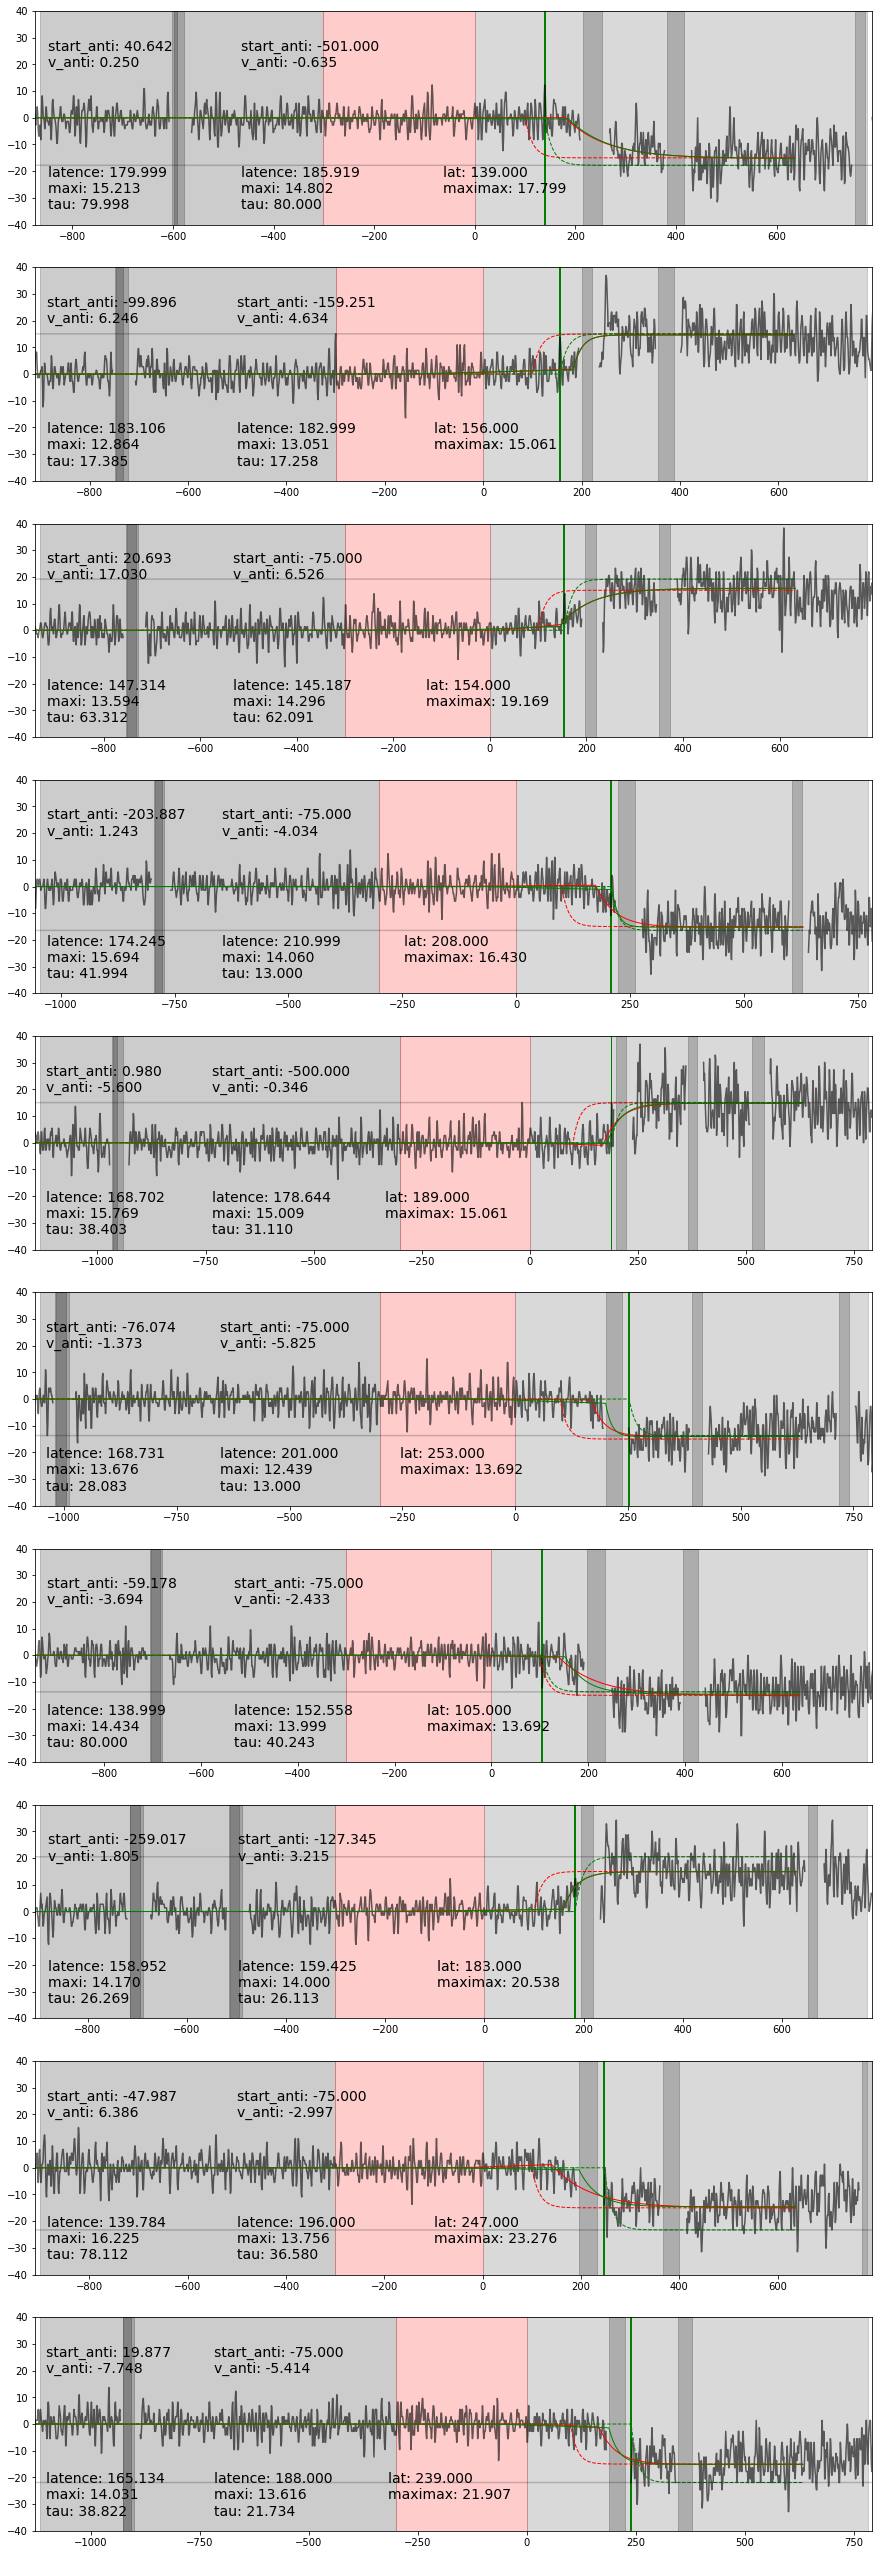

In [8]:
result_fit = Fit(data, nb=50)

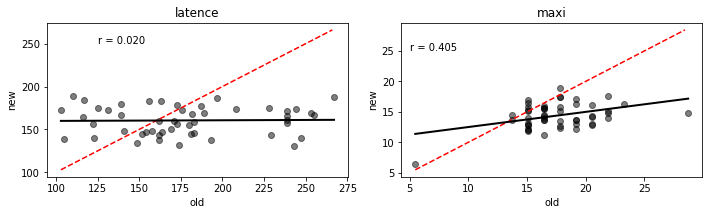

In [9]:
plot(result_fit, num_plot=1)

## old (after fitting with old as init) vs new



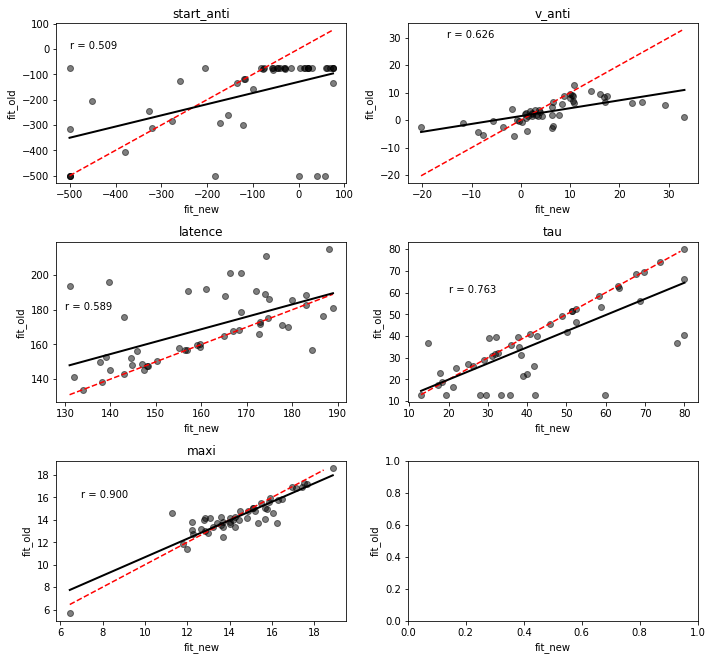

In [10]:
plot(result_fit, num_plot=0)